# Mandelbrot Set
The Mandelbrot set is the set of complex numbers $c$ for which the absolute value of the sequence $z_n$ remains bounded for all $n > 0$, where $z_n$ is:
$$
\begin{align}
z_0 &= 0, \\
z_{n+1} &= z_n^2 + c.
\end{align}
$$
For any complex number $c$, one of two things will happen:
- The sequence blows up to infinity ($|z_n| \gt 2$)
- The sequence if bounded ($|z_n| \le 2$)

Then, $c$ belongs to the Mandelbrot set $M$ if the second case ($|z_n| \le 2$) holds:
$$
M = \{c \in \mathbb{C} \mid \lvert z_n \rvert \le 2 \}.
$$

In [10]:
#imports
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import multiprocessing as mp
import queue


# plot settings
mpl.rcParams["figure.dpi"] = 180
mpl.rcParams["legend.fontsize"] = 11
mpl.rcParams["font.size"] = 11
#plt.rc("text", usetex=True)
#plt.rc("text.latex", preamble=r"""
# \usepackage{palatino}
# \usepackage{newpxmath}""")
plt.rc("font", family="serif")

In [11]:
from cpp_stoch import (
    f_c as f_c_cpp,
    mandelbrot_grid,
    set_num_threads,
    get_num_threads
)

In [12]:
from Function import Monte_carlo, I_iter_worker, S_iter_worker

In [25]:
#Stochastic!
Monte_carlo(sample_size = 20000, max_iter = 100000),\
Monte_carlo(sample_size = 20000, max_iter = 100000),\
Monte_carlo(sample_size = 20000, max_iter = 100000)

(1.4837760000000002, 1.4743680000000001, 1.4827680000000003)

In [13]:

def S_iter(max_iter, n_runs, S_min_exp, S_max_exp):
    manager = mp.Manager()
    
    Approx_areas_list = manager.list()  
    sample_size_range = np.logspace(S_min_exp, S_max_exp, num = (S_max_exp - S_min_exp) + 1, dtype = int)
    
    work_queue = mp.Queue()
    for i in range(n_runs):
        Approx_areas_list.append(manager.list())
        for sample_size in sample_size_range:
            work_queue.put((sample_size, i))
        
                
    processes = []
    for i in range(mp.cpu_count()):
        p = mp.Process(target=S_iter_worker, args=(work_queue, Approx_areas_list, max_iter))
        p.daemon = True
        p.start()
        processes.append(p)

    for p in processes:
        p.join()
    
    return [list(v) for v in Approx_areas_list], sample_size_range        

In [14]:
def Plotter_S(Approx_areas_list, sample_size_range):
    Approx_areas_list_array = np.array(Approx_areas_list)
    Area_means = np.mean(Approx_areas_list_array, axis = 0)
    Area_std = np.std(Approx_areas_list_array, axis = 0)
    Error = np.abs(Area_means - Area_means[-1])


    std_lower = Area_means - Area_std
    std_upper = Area_means + Area_std
    
    fig,ax = plt.subplots()
    ax.plot(sample_size_range, Area_means, color = "red")
    ax.fill_between(sample_size_range, std_lower, std_upper, color='red', alpha=0.1)

    ax2=ax.twinx()
    ax2.plot(sample_size_range, Error, color = "black", linestyle='dashed')
    
    
    ax.set_xlabel("Number of samples (S)")
    ax.set_xscale('log')
    ax.set_ylabel("Mean approximated area")
    ax.set_ylim(np.min(std_lower)-0.01, np.max(std_upper)+0.01)
    #ax2.set_ylabel("Difference mean area $\\left(\\left\\lvert A_j - A_i\\right\\rvert\\right)$")
    ax2.set_ylabel("Difference mean area (A_j - A_i)")

    
    plt.grid(alpha=0.7)
    plt.show()

In [15]:
%%time
Approx_areas_list, sample_size_range = S_iter(max_iter = int(1e4), n_runs = 50, S_min_exp = 3, S_max_exp = 7)

Wall time: 27min 32s


In [16]:
Approx_areas_list_array = np.array(Approx_areas_list)
Area_means = np.mean(Approx_areas_list_array, axis = 0)
Area_std = np.std(Approx_areas_list_array, axis = 0)
Error = np.abs(Area_means - Area_means[-1])

In [17]:
print("Means: ", Area_means)
print("Error: ", Error)
print("Std: ", Area_std)

Means:  [1.509312   1.5078336  1.50711725 1.50591007 1.50681943]
Error:  [0.00249257 0.00101417 0.00029782 0.00090936 0.        ]
Std:  [0.08518246 0.02876411 0.00899045 0.0028065  0.00088545]


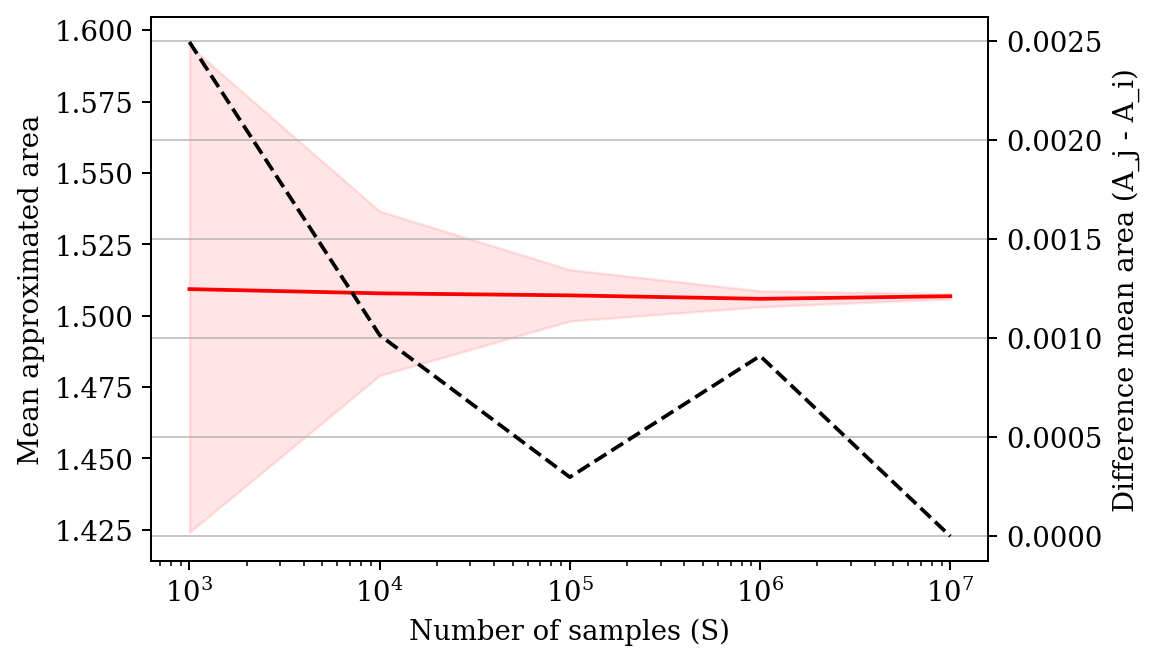

In [18]:
Plotter_S(Approx_areas_list, sample_size_range)

Comments on this plot: This plot is needed to show that we picked the right values for S and I. I do not think this should be a final plot and I have my doubts. This plots main idea is to show convergence of the final value, both in the standard deviation and in the difference with final value. To make this a better plot the n_vars and number of steps needs to be increased way more. We could potentially also muliple lines for different values of the fixed iteration number. 

In [19]:

            
def I_iter(sample_size, n_runs, I_min_exp, I_max_exp):
    if __name__ == "__main__":
        manager = mp.Manager()

        Approx_areas_list = manager.list()  
        iteration_range = np.logspace(I_min_exp, I_max_exp, num = (I_max_exp - I_min_exp) + 1, dtype = int)

        work_queue = mp.Queue()
        for i in range(n_runs):
            Approx_areas_list.append(manager.list())
            for max_iter in iteration_range:
                work_queue.put((max_iter, i))


        processes = []
        for i in range(mp.cpu_count()):
            p = mp.Process(target=I_iter_worker, args=(work_queue, Approx_areas_list, sample_size))
            #p.daemon = True
            p.start()
            processes.append(p)

        for p in processes:
            p.join()

        return [list(v) for v in Approx_areas_list], iteration_range

In [20]:
def Plotter_I(Approx_areas_list, iteration_range):
    Approx_areas_list_array = np.array(Approx_areas_list)
    Area_means = np.mean(Approx_areas_list_array, axis = 0)
    Area_std = np.std(Approx_areas_list_array, axis = 0)
    Error = np.abs(Area_means - Area_means[-1])


    std_lower = Area_means - Area_std
    std_upper = Area_means + Area_std
    
    fig,ax = plt.subplots()
    ax.plot(iteration_range, Area_means, color = "red")
    ax.fill_between(iteration_range, std_lower, std_upper, color='red', alpha=0.1)

    ax2=ax.twinx()
    ax2.plot(iteration_range, Error, color = "black", linestyle='dashed')
    
    
    ax.set_xlabel("Number of iteration (i)")
    ax.set_xscale('log')
    ax.set_ylabel("Mean approximated area")
    ax.set_ylim(1.4, 1.6)
    ax2.set_ylabel("Difference mean area (A_j - A_i)")

    plt.grid()
    plt.show()

In [23]:
%%time

Approx_areas_list_I, iteration_range_I = I_iter(sample_size = int(1e4), n_runs = 50, I_min_exp = 3, I_max_exp = 7)

Wall time: 13min 53s


In [24]:
Approx_areas_list_array_I = np.array(Approx_areas_list_I)
Area_means_I = np.mean(Approx_areas_list_array_I, axis = 0)
Area_std_I = np.std(Approx_areas_list_array_I, axis = 0)
Error_I = np.abs(Area_means_I - Area_means_I[-1])

In [25]:
print("Means: ", Area_means_I)
print("Error: ", Error_I)
print("Std: ", Area_std_I)

Means:  [1.50945984 1.49901696 1.50881472 1.50623424 1.50431232]
Error:  [0.00514752 0.00529536 0.0045024  0.00192192 0.        ]
Std:  [0.02839573 0.02878559 0.02795934 0.02472269 0.02776138]


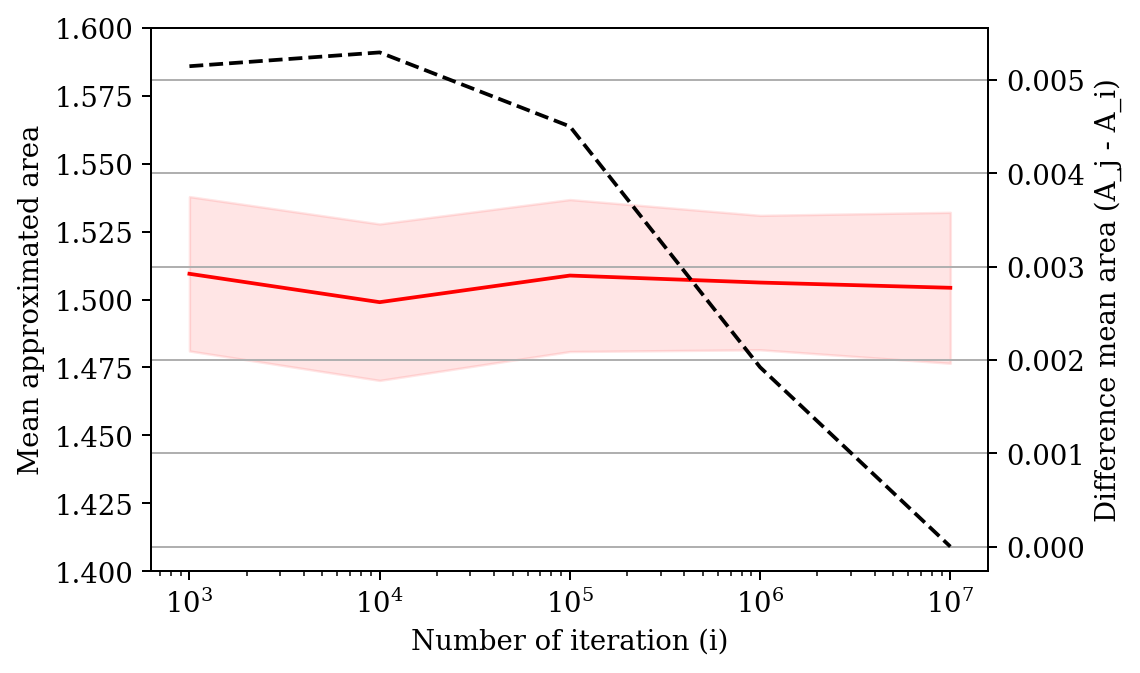

In [26]:
Plotter_I(Approx_areas_list_I, iteration_range_I)

Comment on plot: The size of the standard deviation is caused by the sample size, so that won't change. IT is strange though that the number of iterations has very little impact on convergence. Either we need to increase the amount of samples and runs (perhaps the variability is caused by not an accurate representation), or perhaps the number of iterations has little impact. I could also increase it still, but it takes quite a while to run. 